# Catégorisez automatiquement des questions
## Modélisation : Présentation de différents modèles de prédiction (Stack Overflow)
### OpenClassRooms

**réalisation** : Fabrice Deprez
**date**        : 06/20223

pour rappel,

a partir de l'API Stack Overflow, nous allons récupérer un ensemble de données que nous allons étudier
[Data](https://data.stackexchange.com/stackoverflow/query/new)

la requête doit avoir :

   * un nombre de vue 
   * des commentaires 
   * des réponses
   * des mise en favoris
   * un score significatif
   * au moins 5 tags

`SELECT TOP 500000 CreationDate, Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount
FROM Posts 
WHERE CreationDate, ViewCount > 10 
AND FavoriteCount > 10
AND Score > 5 AND 
AnswerCount > 0 
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5`

Ce notebook contient diiférentes approches (models supervisés et non supervisés) et la comparaison afin de prédire les tags pour les commentaires à partir des données de stack overflow

### Importations

In [21]:
 #!pip install html5lib
#!pip install pyLDAvis
#!pip install torch torchvision
#!pip install tensorflow
#!pip install numpy==1.20.3
#!pip install matplotlib
#!pip install nltk
#!pip install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/21/02/ae8e595f45b6c8edee07913892b3b41f5f5f273962ad98851dc6a564bbb9/transformers-4.31.0-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/116.9 kB ? eta -:--:--
     --- ------------------------------------ 10.2/116.9 kB ? eta -:--:--
     ------------------------------ -------- 92.2/116.9 kB 1.3 MB/s eta 0:00:01
     ------------------------------------ 116.9/116.9 kB 978.7 kB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.14.1 from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
  Using cached tokenizers-0.13.3-cp39-cp39-win_amd64.whl (3.5 MB)
  Obtaining dependency information for safetensors>=0.3.1 from https://files.pythonhosted.org/packages/e3/83/1b542d7ddc5393767dee413aaffad0da7be4c68b358b919220dac983f141/safetensors-0.3.2-

In [2]:
# Désactiver tous les avertissements
#warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import IPython.display
import lxml
import html5lib
from bs4           import BeautifulSoup
import matplotlib.pyplot as plt
import pickle 
import re

import nltk  
from nltk.corpus   import stopwords
from nltk          import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem     import WordNetLemmatizer
from nltk          import FreqDist
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection         import train_test_split
from sklearn.decomposition           import PCA
from sklearn.preprocessing           import MultiLabelBinarizer
from sklearn.metrics                 import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
from sklearn.neighbors               import KNeighborsClassifier
from sklearn.svm                     import LinearSVC
from sklearn.multiclass              import OneVsRestClassifier
from sklearn.ensemble                import RandomForestClassifier
from sklearn.ensemble                import GradientBoostingClassifier
from sklearn.multiclass              import OneVsRestClassifier

import gensim
from   gensim.models import TfidfModel
import gensim.corpora as corpora
from   gensim import models
from   gensim.utils import simple_preprocess
from   gensim.models.ldamulticore import LdaMulticore
from   gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pprint          import pprint
from IPython.display import HTML
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kaneda\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Chargement des données pré-traitées

In [3]:
# on ne va garder que les colonnes qui nous intéresses (id title body et tags)
data = pd.read_csv('./data/cleaned_data.csv', usecols=['Id','Title', 'Body', 'Tags'], index_col='Id')
data.reset_index(inplace=True)
data.drop(columns='Id', inplace=True)
data.head(10)

,Title,Body,Tags
0,Integer value comparison,<p>I'm a newbie Java coder and I just read a v...,<java><integer><int><equals><autoboxing>
1,How do you handle deploying rails applications...,<p>I recently turned a couple of my plugins in...,<git><plugins><capistrano><deployment><git-sub...
2,Golang converting from rune to string,"<p>I have the following code, it is supposed t...",<string><parsing><go><unicode><rune>
3,Java substring: 'String index out of range',<p>I guess I'm getting this error because the ...,<java><string><substring><indexoutofboundsexce...
4,Number of threads used by Go runtime,<p>How many threads can the Go runtime (schedu...,<multithreading><go><docker><concurrency><goro...
5,C# List Comprehensions = Pure Syntactic Sugar?,<p>Consider the following C# code:</p>\n\n<pre...,<c#><linq><optimization><compiler-construction...
6,Error occurred while decoding OAEP padding,<p>While decrypting text using <code>RSACrypto...,<c#><encryption><rsa><digital-signature><rsacr...
7,Is it possible to share an enum declaration be...,<p>Is there a way to share an enum definition ...,<c#><c++><enums><native><managed>
8,Powermock (With Easymock) no last call on a mo...,<p>I am trying to just run a simple test case....,<java><unit-testing><junit><easymock><powermock>
9,"Breakpoint for ""Warning: Attempt to present * ...",<p>Sometimes it happens that - from different ...,<ios><objective-c><swift><uiviewcontroller><br...


### CORPUS

Un corpus est un ensemble organisé et systématique de textes écrits ou parlés, généralement collectés dans un but spécifique pour des analyses linguistiques, littéraires, ou des études de recherche dans divers domaines. Les corpus jouent un rôle essentiel dans l'analyse du langage, car ils permettent aux chercheurs de rassembler un grand volume de données textuelles pour effectuer des études quantitatives et qualitatives.

on va créer une variable regroupant titre et contenue (title and body)

In [4]:
%%time
data['Post'] = data.apply(lambda x: x['Title'] + ' ' + x['Body'] if x['Title'] == x['Title'] else x['Body'], axis=1)
corpus       = data['Post'].to_list()
tags         = data['Tags'].to_list()

print(f"Occurences dans le corpus: {len(corpus)}")
print(f"Occurences dans les tags: {len(tags)}")

Occurences dans le corpus: 48926
Occurences dans les tags: 48926
CPU times: total: 562 ms
Wall time: 642 ms


In [5]:
display(corpus[0])

"Integer value comparison <p>I'm a newbie Java coder and I just read a variable of an integer class can be described three different ways in the API.  I have the following code: </p>\n\n<pre><code>if (count.compareTo(0)) { \n            System.out.println(out_table);\n            count++;\n    }\n</code></pre>\n\n<p>This is inside a loop and just outputs <code>out_table</code>.<br>\nMy goal is to figure out how to see if the value in integer <code>count &gt; 0</code>. </p>\n\n<p>I realize the <code>count.compare(0)</code> is the correct way? or is it <code>count.equals(0)</code>?  </p>\n\n<p>I know the <code>count == 0</code> is incorrect. Is this right? Is there a value comparison operator  where its just <code>count=0</code>?  </p>\n"

dans notre texte, il y a des balides HTML, des lettres en majuscules, des mots spécifique de la langue comme des articles, etc (égaux ou moins de 3 lettres) de l'anglais
nous pouvons donc générer une fonction de nettoyage a la fois de l'HTML et du texte.
pour certains mots clé du code (exemple c++, nous allons les conserver mais en les remplaçant par des mots spécifiques, qu'il faudra restituer par la suite, exemple c++ deviendra cplusplus)

In [89]:
# cette cellul contient toutes les fonctions nécessaire a la modélisation par classification
# ces foctions sont reprises dans l'API

## Nettoyage
def clean_text(text):
    """
    cette fonction permet de nettoyer un texte, la base du texte est supposée en anglais
    Args:    
        text(String): text à nettoyer       
    Returns    
        cleaned_text(String): texte nettoyé (balise html, majuscule, code spécifique, articles, etc).
    """
    text = BeautifulSoup(text, "html5lib")

    for sent in text(['style', 'script']):
            sent.decompose()
            
    text = ' '.join(text.stripped_strings)        

    # Supprimer la ponctuation et les caractères spéciaux
    text = re.sub('[^a-zA-Z0-9]', ' ', text)

    # Mettre en minuscule
    text = text.lower()

    # Remplacer les mots spécifiques
    text = re.sub(r'\bC\+\+\b', 'cplusplus', text)
    #attention a casesentivie
    text = re.sub(r'\b5G\b', 'fiveg', text, flags=re.IGNORECASE)
    text = re.sub(r'\b4G\b', 'fourg', text, flags=re.IGNORECASE)
    # Ajoutez d'autres remplacements si nécessaire pour les mots spécifiques

    # Supprimer les mots vides
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatisation
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Rejoindre les tokens en une chaîne de caractères
    cleaned_text = ' '.join(tokens)

    return cleaned_text


## Tokenisation
def tokenize(text):
    """
    Tokeniser les mots d'un texte.    
    Args:    
        text(String): texte a tokeniser       
    Returns    
        res(list): Chaîne tokenisée.
    """
    stop_words = set(stopwords.words('english'))    
    try:
        res = word_tokenize(text, language='english')
    except TypeError:
        return text
    
    res = [token for token in res if token not in stop_words]
    return res


## Filtrage
def filtering_nouns(tokens):
    """
    Filtrer les noms singuliers    
    Args:
        tokens(list): liste de tokens
    Returns:
        res(list): liste de tokens filtrés
    """ 
    res = nltk.pos_tag(tokens)   
    res = [token[0] for token in res if token[1] == 'NN']    
    return res

## Lemmatisation
def lemmatization(tokens):
    """
    Transforme les tokens en lems     
    Args:
        tokens(list): liste de tokens      
    Returns:
        lemmatized(list): liste de tokens lemmatisés
    """
    import nltk
    from nltk.stem import WordNetLemmatizer
    
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    
    for token in tokens:
        lemmatized.append(lemmatizer.lemmatize(token))
        
    return lemmatized


## analyse
def build_word_distribution(corpus):
    """
    Construire la distribution des mots du corpus    
    Args:
        Corpus(List of lists): corpus    
    Returns:        
        word_dist_df(DataFrame): fréquence de distribution des mots du corpus
    """
    
    from nltk import FreqDist
    word_corpus = [token for token_list in corpus for token in token_list]
    word_dist = FreqDist(word_corpus)
    word_dist_df = pd.DataFrame(word_dist.items(), columns=['Word', 'Frequency']).set_index('Word')
    word_dist_df.sort_values("Frequency", ascending=False, inplace=True)

    return word_dist_df


def metrics_report(model_name, test_labels, predictions, performances):
    """
    Calculer les mesures de performance d'un modèle et les stocker dans un dictionnaire  
    Args:
        model_name(string): nom du modèle évaluél
        test_labels(array): labels liées aux prédicteurs
        preductions(array): résultats prédits
        performances(dict): dictionnaire utilisé pour stocker les mesures
    Returns:
        performances(dict): dictionnaire utilisé pour stocker les métriques classées avec les modèles
    """    
    accuracy = accuracy_score(test_labels, predictions)
    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + model_name + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    
    performances[model_name] = {}
    performances[model_name]["micro_precision"] =  micro_precision
    performances[model_name]["micro_recall"] = micro_recall
    performances[model_name]["micro_f1"] = micro_f1
    
    return performances


## Supervisé (prédiction et test) FD-IDF
def predict_supervised_tags_IDF(supervised_model, mlb_model, text):
    """
    Prédire les balises en fonction d'un texte lemmatisé à l'aide d'un modèle supervisé.     
    Args:
        supervised_model(): Mode utilisé pour obtenir une prédiction
        mlb_model(): Modèle utilisé pour détransformer
    Returns:
        res(list): Liste des tags prédits
    """
    res = tfidf_vectorizer.transform(text)
    res = pd.DataFrame(res.toarray(), columns=vocabulary)
    res = pca.transform(res)
    res = supervised_model.predict(res)
    res = mlb.inverse_transform(res)
    res = list({tag for tag_list in res for tag in tag_list if (len(tag_list) != 0)})
    res = [tag for tag  in res if tag in text]
    
    return res


def check_tag_predction_IDF(original_text, original_tags, preprocessed_text, model):
    """
    Vérifie les balises originales par rapport aux balises prédites pour un article.    
   Args:
        post(list) : text d'origine
        original_tags(list) : preprocessed_tags
    """
    
    predicted_tags = predict_supervised_tags(model, mlb, preprocessed_text)
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"Liste des tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle: {predicted_tags}")

def predict_supervised_tags(supervised_model, mlb_model, text, model, embedding_dim):
    """
    Prédire les balises en fonction d'un texte lemmatisé à l'aide d'un modèle supervisé.
    
    Args:
        supervised_model(): Modèle utilisé pour obtenir une prédiction
        mlb_model(): Modèle utilisé pour détransformer
        text (str): Texte à prédire
        model (gensim.models.Word2Vec): Modèle Word2Vec pour transformer le texte
        embedding_dim (int): Dimension des embeddings

    Returns:
        res(list): Liste des tags prédits
    """
    
    # Transformer le texte avec Word2Vec
    embedding = get_doc_embedding(text, model, embedding_dim) #.split()
    transformed_text = np.array([embedding])
    
    # Prédiction avec le modèle supervisé
    predicted = supervised_model.predict(transformed_text)
    tags = mlb_model.inverse_transform(predicted)
    
    # Filtrer les tags non pertinents
    predicted_tags = list({tag for tag_list in tags for tag in tag_list if (len(tag_list) != 0)})
    relevant_tags = [tag for tag in predicted_tags if tag in text]
    
    return relevant_tags


def check_tag_predction(original_text, original_tags, preprocessed_text, model, w2v_model, embedding_dim):
    """
    Vérifie les balises originales par rapport aux balises prédites pour un article.    
    Args:
        post(list) : text d'origine
        original_tags(list) : preprocessed_tags
        preprocessed_text (list): texte pré-traité
        model: modèle supervisé pour la prédiction
        w2v_model: modèle Word2Vec pour la transformation du texte
        embedding_dim: dimension des embeddings
    """
    
    predicted_tags = predict_supervised_tags(model, mlb, preprocessed_text, w2v_model, embedding_dim)
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"Liste des tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle: {predicted_tags}")

    
## Non supervisé
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Calculer la cohérence c_v pour un nombre variable de sujets
    Args:
        dictionary : dictionnaire Gensim
        corpus     : corpus Gensim
        texts      : textes d'entrées
        limit      : Nombre max de sujets
    Returns:    
        model_list : Liste des modèles thématiques LDA
        coherence_values : Valeurs de cohérence correspondant au modèle LDA avec un nombre respectif de sujets
    """
    coherence_values = []
    model_list = []
    
    
    for num_topics in range(start, limit, step):
        
        model = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=num_topics, 
                            random_state=42,
                            passes=10,
                            workers=7)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


def compute_coherence_values(dictionary, corpus, texts, start, limit, step, passes=5, alpha='symmetric', beta=None, minimum_probability=0.01, random_state=None):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    passes: Number of passes through the corpus during training.
    alpha and beta: Hyperparameters affecting topic density.
    minimum_probability: Minimum probability threshold.

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes, alpha=alpha, eta=beta, minimum_probability=minimum_probability, random_state=random_state)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [7]:
%%time
cleaned_corpus = [clean_text(text) for text in corpus]
cleaned_tags = [clean_text(text).strip() for text in tags]

display(cleaned_corpus[0])
print("\n")
display(cleaned_tags[0])
print("\n")

'integer value comparison newbie java coder read variable integer class described three different way api following code count compareto 0 system println table count inside loop output table goal figure see value integer count 0 realize count compare 0 correct way count equal 0 know count 0 incorrect right value comparison operator count 0'

''



CPU times: total: 3min 18s
Wall time: 3min 21s


### Tokenization

La tokenisation consiste à prendre des textes en entrée et à les convertir en une liste de termes individuels (tokens). Pendant ce processus, les termes génériques (stop words) ne sont pas inclus dans la liste des tokens.

In [8]:
%%time
tokenized_corpus = [tokenize(text) for text in cleaned_corpus]
tokenized_tags = [tokenize(text) for text in cleaned_tags]

print("tokenized_corpus\n")
display(tokenized_corpus[0])
print("\n")
print(f"Longueur du premier éléments tokenized_corpus: {len(tokenized_corpus[0])}")
print("\n")

print("Premier élément de la liste tokenized_tags\n")
display(tokenized_tags[0])
print('\n')


print(f"Occurences dans le corpus tokenizé: {len(tokenized_corpus)}")
print(f"Occurences dans la liste des tags: {len(tokenized_tags)}")

tokenized_corpus



['integer',
 'value',
 'comparison',
 'newbie',
 'java',
 'coder',
 'read',
 'variable',
 'integer',
 'class',
 'described',
 'three',
 'different',
 'way',
 'api',
 'following',
 'code',
 'count',
 'compareto',
 '0',
 'system',
 'println',
 'table',
 'count',
 'inside',
 'loop',
 'output',
 'table',
 'goal',
 'figure',
 'see',
 'value',
 'integer',
 'count',
 '0',
 'realize',
 'count',
 'compare',
 '0',
 'correct',
 'way',
 'count',
 'equal',
 '0',
 'know',
 'count',
 '0',
 'incorrect',
 'right',
 'value',
 'comparison',
 'operator',
 'count',
 '0']



Longueur du premier éléments tokenized_corpus: 54


Premier élément de la liste tokenized_tags



[]



Occurences dans le corpus tokenizé: 48926
Occurences dans la liste des tags: 48926
CPU times: total: 48.3 s
Wall time: 48.8 s


### Filtrages par POS Tagging

Le filtrage des noms est réalisé en utilisant un modèle de POS tagging. Lors du pré-traitement des posts, notre objectif principal est d'identifier les termes liés aux technologies utilisées, qui sont généralement des noms. Pour mettre en œuvre ce filtrage, nous faisons appel à un modèle de POS (Part-of-Speech) tagging basé sur des chaînes de Markov. Ce modèle vise à déterminer la fonction grammaticale la plus probable d'un terme en se basant sur deux éléments :

La fonction grammaticale du terme précédent.
La probabilité la plus élevée de l'association entre le terme et une fonction grammaticale spécifique.

In [9]:
%%time
noun_corpus = [filtering_nouns(tokens) for tokens in tokenized_corpus]

print("Premier élément de la liste noun_corpus\n")
display(noun_corpus[0])
print("\n")

print(f"Longueur du premier éléments de liste noun_corpus: {len(noun_corpus[0])}")
print("\n")


print(f"Occurences dans le corpus tokenizé: {len(noun_corpus)}")

Premier élément de la liste noun_corpus



['integer',
 'value',
 'comparison',
 'java',
 'coder',
 'class',
 'way',
 'code',
 'count',
 'compareto',
 'system',
 'println',
 'table',
 'count',
 'output',
 'goal',
 'figure',
 'value',
 'integer',
 'count',
 'realize',
 'count',
 'way',
 'count',
 'count',
 'incorrect',
 'value',
 'comparison',
 'operator',
 'count']



Longueur du premier éléments de liste noun_corpus: 30


Occurences dans le corpus tokenizé: 48926
CPU times: total: 5min 41s
Wall time: 5min 43s


### Lemmatisation

Pour éviter l'utilisation de multiples formes d'un même terme (conjugaisons, féminin, pluriel, etc.), deux méthodes couramment utilisées sont le stemming et la lemmatisation. Ces deux approches visent à réduire les variations de termes en conservant uniquement leur racine. Le stemming consiste à tronquer les mots de manière simple. Cependant, cette méthode peut entraîner un problème car plusieurs mots sémantiquement différents peuvent avoir la même racine (stem).

En revanche, la lemmatisation identifie la racine sémantique (lemme) d'un terme en se référant à un corpus ou à un dictionnaire de la langue. Cette méthode évite a priori la réduction du nombre de termes ayant une même racine mais des lemmes différents. C'est pourquoi nous privilégions la lemmatisation.

Néanmoins, nous sommes confrontés à la limitation des outils fournis par NLTK. Par exemple, après la lemmatisation, "keras" (Framework de deep learning) devient "kera".

In [10]:
%%time
lemmatized_corpus = [lemmatization(tokens) for tokens in noun_corpus]
lemmatized_tags = [lemmatization(tokens) for tokens in tokenized_tags]

tags_wo_blanks = []
for tokens in lemmatized_tags:
    tokens = [token for token in tokens if len(token)>1]
    tags_wo_blanks.append(tokens)

print("Premier élément de la liste \n")
display(lemmatized_corpus[0])
print("\n")

print(f"Longueur du premier éléments corpus: {len(lemmatized_corpus[0])}")
print("\n")

print("Premier élément de la liste tags\n")
display(tags_wo_blanks[0])


print(f"Occurences dans le corpus lemmatisé: {len(lemmatized_corpus)}")
print(f"Occurences dans les tags lemmatisés: {len(tags_wo_blanks)}")

Premier élément de la liste 



['integer',
 'value',
 'comparison',
 'java',
 'coder',
 'class',
 'way',
 'code',
 'count',
 'compareto',
 'system',
 'println',
 'table',
 'count',
 'output',
 'goal',
 'figure',
 'value',
 'integer',
 'count',
 'realize',
 'count',
 'way',
 'count',
 'count',
 'incorrect',
 'value',
 'comparison',
 'operator',
 'count']



Longueur du premier éléments corpus: 30


Premier élément de la liste tags



[]

Occurences dans le corpus lemmatisé: 48926
Occurences dans les tags lemmatisés: 48926
CPU times: total: 10.3 s
Wall time: 10.6 s


### Nettoyage du corpus

il faut maintenant effectuer une étape importante de prétraitement sur un corpus textuel, en éliminant les valeurs vides, et crée un nouveau corpus filtré qui est ensuite enregistré dans des fichiers pour une utilisation ultérieure

pour cela :

* effectuer le prétraitement du corpus en lemmatisant le texte et en éliminant les balises vides (tags_wo_blanks).

* Les deux parties du corpus, le texte et les tags prétraités, sont ensuite regroupées en deux DataFrames distincts (corpus_df et tag_df). Pour chaque DataFrame, une colonne supplémentaire est ajoutée pour indiquer la longueur du texte ou des tags prétraités (en nombre de caractères).

* Les deux DataFrames corpus_df et tag_df sont ensuite fusionnés pour former un nouveau DataFrame corpus_tag_df, contenant le texte prétraité et les tags prétraités, ainsi que leur longueur respective.

* il faut identifier les lignes dans corpus_tag_df où la longueur du texte ou des tags est égale à zéro, ce qui signifie qu'ils sont vides. Ces lignes sont ensuite supprimées du DataFrame corpus_tag_df ainsi que du DataFrame original data.

* créer ensuite trois listes : filtered_corpus, filtered_tags, et filtered_original_posts. Ces listes contiennent respectivement le texte prétraité, les tags prétraités, et les messages originaux filtrés après avoir éliminé les valeurs vides.

* Les données filtrées sont ensuite enregistrées dans deux fichiers : un fichier CSV nommé "cleaned_corpus.csv" et un fichier binaire de données sérialisées nommé "cleaned_corpus.pkl".

* afficher le nombre d'observations restantes dans le corpus traité et affiche les 10 premières lignes du DataFrame corpus_tag_df.

In [11]:
%%time
#print(f"Observations restante du corpus original: {data.shape[0]}")

#joined_corpus = [" ".join(text) for text in lemmatized_corpus]
#corpus_df = pd.DataFrame(joined_corpus, columns=['preprocessed_text'])
#corpus_df['len_text'] = corpus_df['preprocessed_text'].apply(lambda x: len(x))

#joined_tags = [" ".join(tags) for tags in tags_wo_blanks]
#tag_df = pd.DataFrame(joined_tags, columns=['preprocessed_tags'])
#tag_df['len_tags'] = tag_df['preprocessed_tags'].apply(lambda x: len(x))

#corpus_tag_df = corpus_df.join(tag_df)

#filtered_data = corpus_tag_df[(corpus_tag_df['len_text'] != 0) & (corpus_tag_df['len_tags'] != 0)]
#filtered_corpus = filtered_data['preprocessed_text'].str.split(' ').to_list()
#filtered_tags = filtered_data['preprocessed_tags'].str.split(' ').to_list()
#filtered_original_posts = data.loc[filtered_data.index, 'Post'].tolist()

#filtered_data[['preprocessed_text', 'preprocessed_tags']].to_csv("./data/cleaned_corpus.csv", index=False)
#filtered_data[['preprocessed_text', 'preprocessed_tags']].to_pickle('./models/cleaned_corpus.pkl')

#print(f"Observations restantes du corpus traité: {filtered_data.shape[0]}")
#filtered_data.head(10)

print(f"Observations restante du corpus original: {data.shape[0]}")

joined_corpus = [" ".join(text) for text in lemmatized_corpus]
corpus_df = pd.DataFrame(joined_corpus, columns=['preprocessed_text'])
corpus_df['len_text'] = corpus_df['preprocessed_text'].apply(lambda x: len(x))

joined_tags = [" ".join(tags) for tags in tags_wo_blanks]
tag_df = pd.DataFrame(joined_tags, columns=['preprocessed_tags'])
tag_df['len_tags'] = tag_df['preprocessed_tags'].apply(lambda x: len(x))

corpus_tag_df = pd.concat([corpus_df, tag_df], axis=1)

empty_data_idx = corpus_tag_df[(corpus_tag_df['len_text']==0) | (corpus_tag_df['len_tags']==0)].index

corpus_tag_df.drop(index=empty_data_idx, inplace=True)
data.drop(index=empty_data_idx, inplace=True)

print(f"observations restantes du corpus traité: {corpus_tag_df.shape[0]}")

corpus_tag_df['splitted_text'] = corpus_tag_df['preprocessed_text'].apply(lambda x: x.split(' ') )
corpus_tag_df['splitted_tags'] = corpus_tag_df['preprocessed_tags'].apply(lambda x: x.split(' ') )

filtered_corpus = corpus_tag_df['splitted_text'].to_list()
filtered_tags = corpus_tag_df['splitted_tags'].to_list()
filtered_original_posts = data['Post'].to_list()

filtered_tokenized_vs_original = pd.concat([data['Post'],
                                            corpus_tag_df['splitted_text'], 
                                            corpus_tag_df['splitted_tags']],
                                            axis=1)

filtered_tokenized_vs_original.to_csv("./data/cleaned_corpus.csv", index=False)
filtered_tokenized_vs_original.to_pickle('./models/cleaned_corpus.pkl')

filtered_tokenized_vs_original.head(10)


Observations restante du corpus original: 48926
observations restantes du corpus traité: 4116
CPU times: total: 328 ms
Wall time: 428 ms


,Post,splitted_text,splitted_tags
23,How can I configure Entity Framework to automa...,"[configure, entity, value, column, field, part...",[net]
24,How to perform a binary search on IList<T>? <p...,"[perform, search, ilist, question, perform, se...",[net]
37,Anonymous methods and delegates <p>I try to un...,"[method, delegate, try, begininvoke, method, m...","[net, net]"
44,How to Unit Test Asp.net Membership? <p>I am n...,"[unit, test, membership, unit, membership, stu...",[net]
71,Win32 Console app vs. CLR Console app <p>I'm w...,"[console, app, v, clr, console, app, c, projec...",[net]
86,Why can't I drag execution point in IntelliJ (...,"[execution, point, studio, studio, execution, ...",[net]
93,Why C# is not allowing non-member functions li...,"[member, function, member, function, method, p...",[net]
105,I need some clarification on the MVC architect...,"[clarification, mvc, architecture, architectur...",[tier]
106,mex binding error in WCF <p>I am using VSTS 20...,"[mex, error, wcf, service, statement, app, con...",[net]
117,Regex for Money <p>I have <code>asp:TextBox</c...,"[money, asp, textbox, value, money, e, comma, ...",[net]


### Fréquence de distribution des tokens pour les corpus

In [12]:
%%time
word_dist = build_word_distribution(filtered_corpus)

print(f"Nombre de tokens du corpus {word_dist.shape[0]}")
print("Affichage des 10 tokens les plus utilisés")
display(word_dist.head(20))

Nombre de tokens du corpus 17793
Affichage des 10 tokens les plus utilisés


,Frequency
Word,
system,3273
class,2536
code,2505
file,1935
application,1896
value,1824
type,1741
use,1738
way,1565


CPU times: total: 15.6 ms
Wall time: 141 ms


### Fréquence de distribution des tags

In [13]:
%%time
tag_dist = build_word_distribution(filtered_tags)
print("Top 10 des tags les plus utilisés")
display(tag_dist.head(20))
print(f"Nombre de tags: {len(tag_dist)}")
first_100_tags = tag_dist[0:200].index.to_list()

Top 10 des tags les plus utilisés


,Frequency
Word,
net,3976
core,222
bit,128
64,100
3d,75
htaccess,69
32bit,35
64bit,35
2d,30


Nombre de tags: 260
CPU times: total: 15.6 ms
Wall time: 9.52 ms


# Méthode supervisée

### Top 200 des tags
pour un apprentissage supervisé, il faut limiter le nombre de tags, on va prendre ici le top 200 des tags

In [14]:
print(f"Observations restantes du corpus: {data.shape[0]}")
filtered_corpus_tag_df = corpus_tag_df.copy()
filtered_corpus_tag_df['tags_in_top100'] = filtered_corpus_tag_df['splitted_tags'].apply(lambda tags: [tag for tag in tags if tag in first_100_tags])

filtered_corpus_tag_df['len_tags_in_top100'] = filtered_corpus_tag_df['tags_in_top100'].apply(lambda x: len(x))
missing_filtered_data = filtered_corpus_tag_df[filtered_corpus_tag_df['len_tags_in_top100'] == 0].index

filtered_corpus_tag_df.drop(index=missing_filtered_data, inplace=True)
data.drop(index=missing_filtered_data, inplace=True)
print(f"Observations restantes dans le coprus traité: {filtered_corpus_tag_df.shape[0]}")

top100_corpus = filtered_corpus_tag_df['splitted_text'].to_list()
top100_joined_corpus = filtered_corpus_tag_df['preprocessed_text'].to_list()
top100_tags = filtered_corpus_tag_df['tags_in_top100'].to_list()

Observations restantes du corpus: 4116
Observations restantes dans le coprus traité: 4093


### Fréquences après filtrage pour 100 tags

In [15]:
word_dist_top100 = build_word_distribution(top100_corpus)
print(f"Nombre de tokens du corpus {word_dist_top100.shape[0]}")
print("Affichage des 10 tokens les plus utilisés")
display(word_dist_top100.head(20))
print("Nombre des tokens ayant plus de 1000 occurences sur le corpus filtré")
word_dist_top100[word_dist_top100["Frequency"]>=1000].shape[0]

Nombre de tokens du corpus 17721
Affichage des 10 tokens les plus utilisés


,Frequency
Word,
system,3269
class,2531
code,2493
file,1920
application,1895
value,1821
type,1736
use,1725
name,1558


Nombre des tokens ayant plus de 1000 occurences sur le corpus filtré


29

### faisons pareil pour les tags

In [16]:
tag_dist_top_100 = build_word_distribution(top100_tags)
print("Top 10 des tags les plus utilisés")
display(tag_dist_top_100.head(20))
print(f"Nombre de tags: {len(tag_dist_top_100)}")

Top 10 des tags les plus utilisés


,Frequency
Word,
net,3976
core,222
bit,128
64,100
3d,75
htaccess,69
64bit,35
32bit,35
2d,30


Nombre de tags: 200


### T-IDF ou Bag of Words (BoW) ?

Pour pouvoir entraîner nos modèles, nous devons transformer les listes de tokens lemmatisés en vecteurs. Deux méthodes couramment utilisées sont les suivantes :

* Bag of Words (BoW) : Chaque liste de tokens (appelée document) est convertie en un vecteur indiquant la fréquence brute de chaque terme du corpus dans le document.

* TF-IDF : Cette méthode remplace la fréquence brute d'un token par un indicateur composé de sa fréquence d'apparition dans le document et de la fréquence inverse du nombre de documents où le token apparaît. La formule est TF-IDF = TF × log(|D|/|{d_j ∶ t_i∈d_j }|), où |D| représente le nombre total de documents dans le corpus et |{d_j ∶ t_i∈d_j }| représente le nombre de documents dans lesquels le token apparaît. Cette méthode permet de minimiser l'importance des tokens présents dans un grand nombre de documents et de normaliser la taille des documents.

En raison de la présence de termes très génériques et de longueurs de documents très variables, nous avons opté pour la vectorisation par TF-IDF pour nos travaux futurs. Pour ne conserver que les tokens les plus représentatifs, nous avons entraîné les modèles de vectorisation en utilisant un dictionnaire de correspondance (vocabulary) qui ne contient que des termes apparaissant plus de 1000 fois dans le corpus. Cette approche nous permettra de mieux capturer les caractéristiques importantes du texte tout en éliminant les termes moins informatifs.

In [17]:
%%time
vocabulary = list(word_dist_top100[word_dist_top100["Frequency"]>=1000].index)
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary)
X = tfidf_vectorizer.fit_transform(top100_joined_corpus)
tfidf_data = pd.DataFrame(X.toarray(), columns=vocabulary)
print("Affichage des 10 premiers posts vectorisés")
display(tfidf_data.head(10))
print(f" Nombre d'observations: {tfidf_data.shape[0]}, nombre de variables: {tfidf_data.shape[1]}")

filename_tfidf_model = './models/tfidf_model.pkl'
pickle.dump(tfidf_vectorizer, open(filename_tfidf_model, 'wb'))

filename_vocabulary = "./models/vocabulary.pkl"
pickle.dump(vocabulary, open(filename_vocabulary, 'wb'))

Affichage des 10 premiers posts vectorisés


,system,class,code,file,application,value,type,use,name,way,...,test,service,time,http,problem,task,string,example,exception,net
0,0.000000,0.000000,0.000000,0.000000,0.171685,0.967233,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.16535,0.134204,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.16008,0.0,0.000000,0.0,0.0,0.000000
2,0.180390,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000
3,0.000000,0.000000,0.060530,0.303563,0.070947,0.000000,0.00000,0.000000,0.000000,0.129393,...,0.74382,0.000000,0.081473,0.000000,0.00000,0.0,0.167639,0.0,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.387028,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000
6,0.000000,0.913163,0.134809,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.17154,0.0,0.000000,0.0,0.0,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.681054
8,0.200814,0.000000,0.000000,0.105750,0.000000,0.000000,0.00000,0.000000,0.354771,0.000000,...,0.00000,0.684408,0.000000,0.490668,0.00000,0.0,0.000000,0.0,0.0,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.777914,0.00000,0.628371,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000


 Nombre d'observations: 4093, nombre de variables: 29
CPU times: total: 62.5 ms
Wall time: 199 ms


## Embedding

### TF-IDF:

Met l'accent sur l'importance des mots dans le document par rapport à l'ensemble du corpus.
Chaque mot est traité indépendamment, ce qui signifie que cette méthode ne capture pas vraiment les relations sémantiques entre les mots.
La dimension du vecteur est égale au nombre de mots (ou de bigrammes, trigrammes, etc.) dans le corpus.
### Embeddings (comme Word2Vec):

Capture les relations sémantiques entre les mots en se basant sur leur contexte dans le corpus.
La dimension du vecteur est généralement beaucoup plus petite (comme 100, 200, 300 dimensions) et est fixée à l'avance.
Capable de capturer des analogies et des relations sémantiques entre les mots.

In [18]:
full_corpus = corpus_tag_df['preprocessed_text'].to_list()

# 1. Création du modèle d'embedding
from gensim.models import Word2Vec

embedding_dim = 100
w2v_model = Word2Vec(full_corpus, vector_size=embedding_dim, window=5, min_count=1, workers=4)
w2v_model.save('./models/word2vec.pkl')

#embedding_dim = 100
#model = Word2Vec(top100_joined_corpus, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# 2. Transformation des documents en vecteurs
def get_doc_embedding(doc, w2v_model, embedding_dim):
    embedding = np.zeros(embedding_dim)
    num_words = 0
    for word in doc:
        if word in w2v_model.wv:
            embedding += w2v_model.wv[word]
            num_words += 1
    if num_words != 0:
        return embedding/num_words    
    return embedding



X = np.array([get_doc_embedding(doc, w2v_model, embedding_dim) for doc in full_corpus])

## Doc2Vec:
Doc2Vec, similaire à Word2Vec, est conçu pour obtenir des vecteurs pour des documents entiers plutôt que pour des mots individuels.

In [19]:
# Convertir chaque string du corpus en une liste de mots
full_corpus_listWords = [doc.split() for doc in corpus_tag_df['preprocessed_text'].tolist()]

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

embedding_dim = 100

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(full_corpus_listWords)]
model_d2v = Doc2Vec(documents, vector_size=embedding_dim, window=5, min_count=1, workers=4)

def get_d2v_embedding(doc, model):
    return model.infer_vector(doc)

X_d2v = np.array([get_d2v_embedding(doc, model_d2v) for doc in full_corpus_listWords])

## BERT:
BERT est un modèle pré-entraîné par Google qui est actuellement l'un des meilleurs pour de nombreuses tâches de traitement du langage naturel.

In [22]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text, model_bert, tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model_bert(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

X_bert = np.array([get_bert_embedding(text, model_bert, tokenizer) for text in full_corpus_listWords])


## GloVe

GloVe est une autre méthode populaire d'obtention de représentations vectorielles pour des mots, similaire à Word2Vec. Cependant, au lieu de s'entraîner sur des fenêtres de mots locaux, GloVe s'entraîne sur des statistiques globales de cooccurrence des mots.

In [23]:
glove_embeddings = load_glove_embeddings('./data/glove.6B.100d.txt')

In [24]:
def get_doc_embedding_glove(doc, embeddings, embedding_dim=100):
    embedding = np.zeros(embedding_dim)
    num_words = 0
    for word in doc:
        if word in embeddings:
            embedding += embeddings[word]
            num_words += 1
    if num_words != 0:
        return embedding/num_words
    return embedding

X_glove = np.array([get_doc_embedding_glove(doc, glove_embeddings, embedding_dim) for doc in full_corpus])

## Universal Sentence Encoder (USE):
USE est également développé par Google et est spécialement conçu pour la conversion de phrases en vecteurs.

## Comparaison embedding :

Pour comparer les embeddings, on peut utiliser une méthode de classification ou de clustering, puis évaluez les résultats obtenus avec chaque embedding.

In [25]:
from sklearn.metrics import classification_report

def evaluate_embeddings(X, y, clf):
    X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X, y, test_size=0.2, random_state=42)
    clf.fit(X_train_emb, y_train_emb)
    preds = clf.predict(X_test_emb)
    return classification_report(y_test_emb, preds, zero_division=1)

# Approche supervisée.

## Entrainement du modèle

### dédoublonnage (labels)

Après avoir prétraité les documents, il est nécessaire de dédoublonner les tags - labels. En effet, il arrive fréquemment que les utilisateurs spécifient plusieurs versions d'une même technologie dans leurs tags. Suite au prétraitement, qui inclut notamment la suppression des caractères numériques, les tags - labels peuvent contenir des doublons pour un même document.

In [26]:
dedoub_tags = []
for tags in top100_tags:
    dedoub_tags.append(set(tags))

print('Affichage de la première occurence ')
display(dedoub_tags[0])

Affichage de la première occurence 


{'net'}

In [ ]:
corpus_tag_df

In [27]:
# Par exemple, si vous avez une colonne 'tags' qui contient les tags sous forme de chaînes séparées par des virgules:
corpus_tag_df['splitted_tags'] = corpus_tag_df['preprocessed_tags'].str.split(',')
dedoub_tags = [set(tags) for tags in corpus_tag_df['splitted_tags']]
print(dedoub_tags)

[{'net'}, {'net'}, {'net net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'tier'}, {'net'}, {'net'}, {'3d'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'browser cache'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net attribute'}, {'profile'}, {'net net'}, {'net net'}, {'2d'}, {'net'}, {'net'}, {'youtube'}, {'net'}, {'net'}, {'32 bit'}, {'net'}, {'3d 2d'}, {'net'}, {'net'}, {'2d'}, {'net'}, {'net'}, {'net net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'google analytics cross domain tracking'}, {'net'}, {'net'}, {'net'}, {'64 bit 32 bit'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net core'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net net'}, {'net core'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}, {'net'}

In [28]:
y_labels = [list(tag_set)[0] for tag_set in dedoub_tags]
print(y_labels[0:10])

['net', 'net', 'net net', 'net', 'net', 'net', 'net', 'tier', 'net', 'net']


In [29]:
print(X_bert.shape)

(4116, 1, 768)


In [30]:
X_bert_2d = X_bert.reshape(X_bert.shape[0], -1) # repassage en 2D

In [31]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
print("Word2Vec Results:\n", evaluate_embeddings(X, y_labels, clf))
print("Doc2Vec Results:\n", evaluate_embeddings(X_d2v, y_labels, clf))
print("BERT Results:\n", evaluate_embeddings(X_bert_2d, y_labels, clf))
print("GloVe Results:\n", evaluate_embeddings(X_glove, y_labels, clf))

Word2Vec Results:
                                          precision    recall  f1-score   support

                               256color       1.00      0.00      0.00         1
                                     2d       1.00      0.00      0.00         4
                                 32 bit       1.00      0.00      0.00         1
                            32bit 64bit       1.00      0.00      0.00         7
                     32bit 64bit 32 bit       1.00      0.00      0.00         1
                                     3d       1.00      0.00      0.00        12
                                  3d 2d       1.00      0.00      0.00         1
                   3d 3d reconstruction       1.00      0.00      0.00         1
         3d modelling 3d reconstruction       1.00      0.00      0.00         1
                                     3g       1.00      0.00      0.00         1
                                 64 bit       1.00      0.00      0.00        10
        

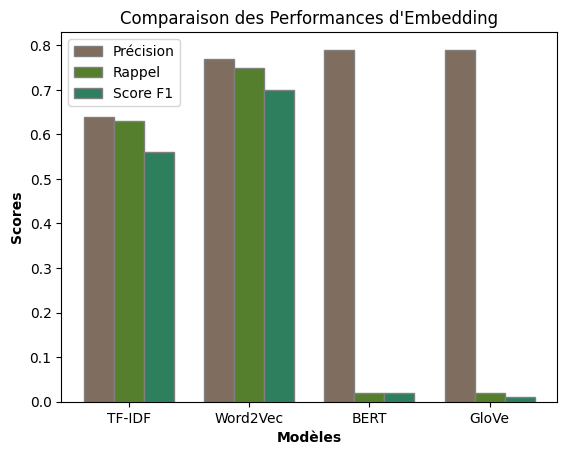

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Données
modèles = ['TF-IDF', 'Word2Vec', 'BERT', 'GloVe']
précision = [0.64, 0.77, 0.79, 0.79]
rappel = [0.63, 0.75, 0.02, 0.02]
score_f1 = [0.56, 0.70, 0.02, 0.01]

barWidth = 0.25

# Positions des bars sur l'axe des x
r1 = np.arange(len(précision))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Création des bars
plt.bar(r1, précision, color='#7f6d5f', width=barWidth, edgecolor='grey', label='Précision')
plt.bar(r2, rappel, color='#557f2d', width=barWidth, edgecolor='grey', label='Rappel')
plt.bar(r3, score_f1, color='#2d7f5e', width=barWidth, edgecolor='grey', label='Score F1')

# Titre & Sous-titre
plt.title('Comparaison des Performances d\'Embedding')
plt.xlabel('Modèles', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')

# Ajout des noms des modèles
plt.xticks([r + barWidth for r in range(len(précision))], modèles)

# Création de la légende & Affichage du graphique
plt.legend()
plt.show()

### entraintement des données

In [33]:
# X_train, X_test, y_train, y_test = train_test_split(tfidf_data, dedoub_tags, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, dedoub_tags, test_size=0.2, random_state=42) # utilistion du modèle Word2Vec

### Réduction 

Suite à la vectorisation, les documents sont transformés en un vecteur à plusieurs composantes. Afin de réduire les dimensions, d'éliminer les corrélations entre ces composantes et d'optimiser le temps d'entraînement des modèles, nous procédons à une Analyse en Composantes Principales (ACP).

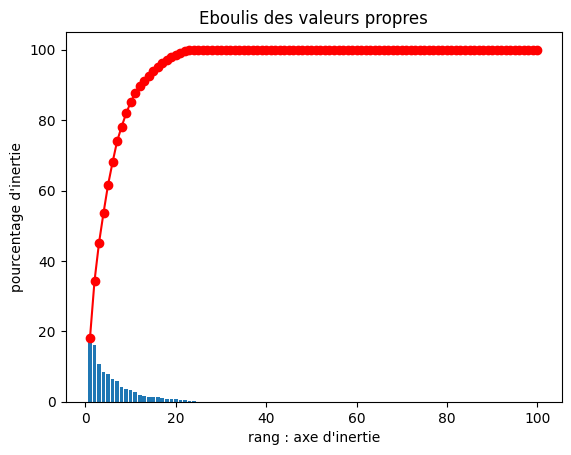

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(random_state=42)
pca.fit(X_train)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang : axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

display_scree_plot(pca)

In [35]:
pca = PCA(n_components=0.85, random_state=42)
pca.fit(X_train)
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)
print(f"Nombre de composantes principales: {pca.components_.shape[0]}")

filename_pca_model = './models/pca_model.pkl'
pickle.dump(pca, open(filename_pca_model, 'wb'))

Nombre de composantes principales: 10


### Vectorisation

In [36]:
mlb = MultiLabelBinarizer(classes=first_100_tags)
train_labels = mlb.fit_transform(y_train)
test_labels = mlb.transform(y_test)

print("Classes du modèle de vectorisation")
display(mlb.classes_)

filename_mlb_model = './models/mlb_model.pkl'
pickle.dump(mlb, open(filename_mlb_model,'wb'))

Classes du modèle de vectorisation


array(['net', 'core', 'bit', '64', '3d', 'htaccess', '32bit', '64bit',
       '2d', 'standard', 'assembly', '32', 'framework', 'cross',
       'internet', 'explorer', 'google', 'embed', 'domain', 'youtube',
       'safari', 'browser', 'version', 'http', 'line', '7zip', 'content',
       'doc', 'reconstruction', 'api', 'break', '16', 'dialog', 'mobile',
       'chrome', 'extension', 'text', 'contenteditable', 'header', 'row',
       'frame', '11', 'responsive', '3g', 'design', 'internals',
       'android', 'postmessage', 'ionic', 'tier', 'alignment',
       'selection', 'newline', 'analytics', 'height', 'figure', 'way',
       'object', 'databinding', 'tracking', 'htpasswd', 'pseudo',
       'scrollbar', 'event', 'cooky', 'refresh', 'policy', 'jquery',
       'modal', 'scroll', 'history', 'whitespace', 'hyperlink', 'wysiwyg',
       'cursor', 'attribute', 'profile', 'option', 'document', 'window',
       'grafana', 'location', 'uinavigationitem', 'native', '3des',
       'onclick', 'tr

### Evaluation


Pour comparer les modèles, quatre indicateurs ont été évalués :

* Précision : évalue la capacité à prédire correctement les tags associés à chaque document.
* Recall : évalue la capacité à retrouver, pour chaque tag, tous les documents qui lui sont associés.
* F1 Score : calcule la moyenne harmonique de la précision et du recall.

Dans le cadre d'une classification multi-classes, les versions "micro" de ces indicateurs ont été utilisées. Concrètement, ces versions sont calculées par classe, puis agrégées là où les indicateurs "macro" sont calculés globalement.

Lors de l'évaluation, l'accent a été mis sur la précision et le temps d'entraînement. Dans le contexte d'une API de suggestion de tags, la capacité d'un modèle à retrouver tous les documents associés à chaque terme n'est pas essentielle. Cependant, le recall et le F1 Score ont tout de même été observés pour affiner l'analyse.

## KNN

In [37]:
%%time
models_performance = {}

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_transformed, train_labels)
knn_predictions = knn_clf.predict(X_test_transformed)
metrics_report("knn", test_labels, knn_predictions, models_performance)

------knn Model Metrics-----
Accuracy: 0.7512
Hamming Loss: 0.0014
Precision:
  - Macro: 0.0040
  - Micro: 0.8079
Recall:
  - Macro: 0.0046
  - Micro: 0.8632
F1-measure:
  - Macro: 0.0043
  - Micro: 0.8346
CPU times: total: 5.97 s
Wall time: 6.15 s


{'knn': {'micro_precision': 0.8079019073569482,
  'micro_recall': 0.8631732168850073,
  'micro_f1': 0.8346235045742435}}

## SVM

In [38]:
%%time
svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
svm_clf.fit(X_train_transformed, train_labels)

svm_preds = svm_clf.predict(X_test_transformed)
metrics_report("svm", test_labels, svm_preds, models_performance)

------svm Model Metrics-----
Accuracy: 0.7864
Hamming Loss: 0.0013
Precision:
  - Macro: 0.0039
  - Micro: 0.7881
Recall:
  - Macro: 0.0050
  - Micro: 0.9418
F1-measure:
  - Macro: 0.0044
  - Micro: 0.8581
CPU times: total: 266 ms
Wall time: 303 ms


{'knn': {'micro_precision': 0.8079019073569482,
  'micro_recall': 0.8631732168850073,
  'micro_f1': 0.8346235045742435},
 'svm': {'micro_precision': 0.7880633373934226,
  'micro_recall': 0.9417758369723436,
  'micro_f1': 0.8580901856763926}}

## Random Forest

In [39]:
%%time
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train_transformed, train_labels)
rf_preds = rf_clf.predict(X_test_transformed)
metrics_report("Random Forest", test_labels, rf_preds, models_performance)

------Random Forest Model Metrics-----
Accuracy: 0.7803
Hamming Loss: 0.0013
Precision:
  - Macro: 0.0040
  - Micro: 0.7957
Recall:
  - Macro: 0.0049
  - Micro: 0.9185
F1-measure:
  - Macro: 0.0044
  - Micro: 0.8527
CPU times: total: 36.3 s
Wall time: 5.76 s


{'knn': {'micro_precision': 0.8079019073569482,
  'micro_recall': 0.8631732168850073,
  'micro_f1': 0.8346235045742435},
 'svm': {'micro_precision': 0.7880633373934226,
  'micro_recall': 0.9417758369723436,
  'micro_f1': 0.8580901856763926},
 'Random Forest': {'micro_precision': 0.7957124842370744,
  'micro_recall': 0.9184861717612809,
  'micro_f1': 0.8527027027027028}}

## Gradient Boosting

In [40]:
%%time
gb_clf = OneVsRestClassifier(GradientBoostingClassifier())
gb_clf.fit(X_train_transformed, train_labels)
gb_preds = gb_clf.predict(X_test_transformed)
metrics_report("Gradient Boosting", test_labels, gb_preds, models_performance)

------Gradient Boosting Model Metrics-----
Accuracy: 0.7621
Hamming Loss: 0.0014
Precision:
  - Macro: 0.0040
  - Micro: 0.7733
Recall:
  - Macro: 0.0049
  - Micro: 0.9287
F1-measure:
  - Macro: 0.0044
  - Micro: 0.8439
CPU times: total: 41.4 s
Wall time: 41.8 s


{'knn': {'micro_precision': 0.8079019073569482,
  'micro_recall': 0.8631732168850073,
  'micro_f1': 0.8346235045742435},
 'svm': {'micro_precision': 0.7880633373934226,
  'micro_recall': 0.9417758369723436,
  'micro_f1': 0.8580901856763926},
 'Random Forest': {'micro_precision': 0.7957124842370744,
  'micro_recall': 0.9184861717612809,
  'micro_f1': 0.8527027027027028},
 'Gradient Boosting': {'micro_precision': 0.7733333333333333,
  'micro_recall': 0.9286754002911208,
  'micro_f1': 0.843915343915344}}

In [41]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
result_df

,micro_precision,micro_recall,micro_f1
knn,0.807902,0.863173,0.834624
svm,0.788063,0.941776,0.858090
Random Forest,0.795712,0.918486,0.852703
Gradient Boosting,0.773333,0.928675,0.843915


### Conclusion

on constate des résultats plus ou moins simulaires, mais s'il faut privilégier les temps d'exécution dans ce type d'algorithme, il est préférable d'utiliser le modèle SVM 
d'autant que ce dernier offre le meilleure score

In [42]:
filename_svm_model = './models/svm_model.pkl'
pickle.dump(svm_clf, open(filename_svm_model,'wb'))

In [43]:
print(X_train_transformed.shape)

(3292, 10)


In [44]:
%%time
#filtered_tokenized_vs_original.reset_index(drop=True, inplace=True)
#check_tag_predction(filtered_tokenized_vs_original.loc[0, 'Post'], 
#                    filtered_tokenized_vs_original.loc[0, 'splitted_tags'],
#                    filtered_tokenized_vs_original.loc[0, 'splitted_text'],
#                    svm_clf)

embedding_w2v = pca.transform(X[0].reshape(1, -1))
embedding_w2v = embedding_w2v.ravel()

filtered_tokenized_vs_original.reset_index(drop=True, inplace=True)
check_tag_predction(
    filtered_tokenized_vs_original.loc[0, 'Post'], 
    filtered_tokenized_vs_original.loc[0, 'splitted_tags'],
    filtered_tokenized_vs_original.loc[0, 'splitted_text'],
    svm_clf,
    w2v_model,  # le modèle Word2Vec
    10  # la dimension d'embedding (10 si vous avez réduit à 10 dimensions avec PCA)
)

Publication originale: 

How can I configure Entity Framework to automatically trim values retrieved for specific columns mapped to char(N) fields? <p>I'm working with a third-party database in which all text values are stored as <code>char(n)</code>. Some of these text values are primary keys, whereas others are just normal human-readable text. For the latter, I want retrieved values to be automatically trimmed.</p>

<p>I know I can add <code>Trim</code> to all of my LINQ to Entities queries, but this is messy, unreliable and unmaintainable. I would like to somehow configure Entity Framework to automatically trim values retrieved from specific columns.</p>

<p>However, I don't know how to do this. I'm using EF's fluent API. The closest thing I've thought of so far is creating additional properties to wrap the real properties with <code>Trim</code> method calls, but this is messy and still not very maintainable. I would also prefer for the trimming to occur in the database rather than 

### Vérification 

# Méthode non supervisée

Pour cette approche, nous utiliserons un modèle LDA (Latent Dirichlet Allocation). Ce modèle génère une distribution de topics par document et une distribution de topics par token en utilisant un nombre restreint de topics, noté k. Pour paralléliser les calculs, nous utiliserons le module LdaMulticore de Gensim.

Nous chercherons à déterminer le modèle ayant l'indice de cohérence maximum. Pour cela, nous devrons définir le nombre de topics que nous souhaitons générer. Nous observerons le score de cohérence pour un ensemble de modèles LDA entraînés avec un hyperparamètre allant de 2 à 50 topics. Ce score de cohérence mesure le degré de similitude sémantique des mots les plus représentés pour chaque topic. Ainsi, il nous permettra de déterminer si chaque topic est cohérent d'un point de vue sémantique ou s'il s'agit d'un amalgame aléatoire de mots. Un score de cohérence élevé indique une meilleure cohérence du topic. Vous trouverez ci-dessous le diagramme montrant l'évolution du score de cohérence en fonction du nombre de topics.

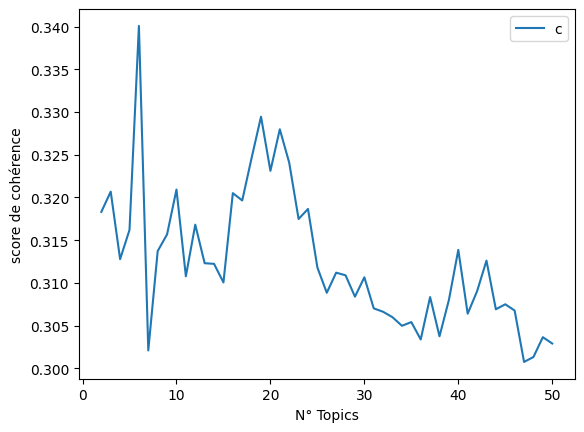

N° Topics = 2  a une valeur de cohérence de 0.3183
N° Topics = 3  a une valeur de cohérence de 0.3207
N° Topics = 4  a une valeur de cohérence de 0.3128
N° Topics = 5  a une valeur de cohérence de 0.3162
N° Topics = 6  a une valeur de cohérence de 0.3401
N° Topics = 7  a une valeur de cohérence de 0.3021
N° Topics = 8  a une valeur de cohérence de 0.3137
N° Topics = 9  a une valeur de cohérence de 0.3157
N° Topics = 10  a une valeur de cohérence de 0.3209
N° Topics = 11  a une valeur de cohérence de 0.3108
N° Topics = 12  a une valeur de cohérence de 0.3168
N° Topics = 13  a une valeur de cohérence de 0.3123
N° Topics = 14  a une valeur de cohérence de 0.3122
N° Topics = 15  a une valeur de cohérence de 0.31
N° Topics = 16  a une valeur de cohérence de 0.3205
N° Topics = 17  a une valeur de cohérence de 0.3196
N° Topics = 18  a une valeur de cohérence de 0.3246
N° Topics = 19  a une valeur de cohérence de 0.3295
N° Topics = 20  a une valeur de cohérence de 0.3231
N° Topics = 21  a une 

In [51]:
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt

# Charger le modèle existant
w2v_model = Word2Vec.load('./models/word2vec.pkl')
embedding_dim = w2v_model.vector_size

data = pd.read_pickle("./models/cleaned_corpus.pkl")
texts = data['splitted_text'].to_list()

# Créer un vrai BOW à partir des données
dictionary = Dictionary(texts)
bow_corpus = [dictionary.doc2bow(doc) for doc in texts]

# Remplacez chaque terme du BOW par son embedding
def bow_to_embedding(doc_bow):
    embedded_doc = np.zeros(embedding_dim)
    for (word_id, freq) in doc_bow:
        word = dictionary[word_id]
        if word in w2v_model.wv:
            embedded_doc += w2v_model.wv[word] * freq
    return embedded_doc / len(doc_bow) if len(doc_bow) != 0 else np.zeros(embedding_dim)

embedded_corpus = [bow_to_embedding(doc_bow) for doc_bow in bow_corpus]

n_bins = 10

def embeddings_to_bins(embedding):
    bins = np.linspace(-1, 1, n_bins)
    embedded_to_bins = [np.digitize(dim, bins) for dim in embedding]
    return [(idx, val) for idx, val in enumerate(embedded_to_bins) if idx < len(dictionary)]

pseudo_bow_corpus = [embeddings_to_bins(vec) for vec in embedded_corpus]

def compute_coherence_values(dictionary, corpus, texts, start, limit, step=1, passes=5, alpha='auto', beta='auto', minimum_probability=0.01, random_state=2023):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes, alpha=alpha, eta=beta, minimum_probability=minimum_probability, random_state=random_state)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# exécution du LDA
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=pseudo_bow_corpus, texts=texts, start=2, limit=51, step=1)

# Et affichage les résultats
limit=51
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("N° Topics")
plt.ylabel("score de cohérence")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("N° Topics =", m, " a une valeur de cohérence de", round(cv, 4))


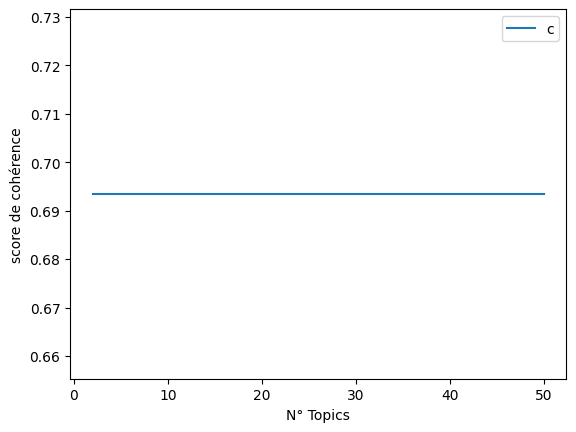

N° Topics = 2  a une valeur de cohérence de 0.6934
N° Topics = 3  a une valeur de cohérence de 0.6934
N° Topics = 4  a une valeur de cohérence de 0.6934
N° Topics = 5  a une valeur de cohérence de 0.6934
N° Topics = 6  a une valeur de cohérence de 0.6934
N° Topics = 7  a une valeur de cohérence de 0.6934
N° Topics = 8  a une valeur de cohérence de 0.6934
N° Topics = 9  a une valeur de cohérence de 0.6934
N° Topics = 10  a une valeur de cohérence de 0.6934
N° Topics = 11  a une valeur de cohérence de 0.6934
N° Topics = 12  a une valeur de cohérence de 0.6934
N° Topics = 13  a une valeur de cohérence de 0.6934
N° Topics = 14  a une valeur de cohérence de 0.6934
N° Topics = 15  a une valeur de cohérence de 0.6934
N° Topics = 16  a une valeur de cohérence de 0.6934
N° Topics = 17  a une valeur de cohérence de 0.6934
N° Topics = 18  a une valeur de cohérence de 0.6934
N° Topics = 19  a une valeur de cohérence de 0.6934
N° Topics = 20  a une valeur de cohérence de 0.6934
N° Topics = 21  a un

In [46]:
%%time 
data    = pd.read_pickle("./models/cleaned_corpus.pkl")
texts   = data['splitted_text'].to_list()
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=1000)
bow_corpus   = [id2word.doc2bow(text) for text in texts]
tfidf        = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=1) #tfidf_corpus

limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("N° Topics")
plt.ylabel("score de cohérence")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("N° Topics =", m, " a une valeur de cohérence de", round(cv, 4))    

on peut constater une cohérence linéaire avec une valeur de cohérence de 0.6934

Lorsque l'algorithme non supervisé (LDA) est appliqué avec différentes valeurs du nombre de topics (de 2 à 50), le tracé plat et constant du score de cohérence à environ 0.6934 suggère que le modèle ne parvient pas à identifier des structures de topics significatives ou cohérentes dans les données.

Une valeur constante de cohérence indique que les mots les plus représentés pour chaque topic ne forment pas de groupe sémantiquement cohérent. Cela peut signifier que les données sont difficiles à regrouper en topics distincts et significatifs avec les paramètres actuels.

Plus précisément, cela peut être dû à plusieurs raisons :

* 1- Le corpus de texte est trop hétérogène : Si les documents couvrent une grande variété de sujets ou de thèmes, il peut être difficile pour l'algorithme LDA de trouver des structures cohérentes dans les données.

* 2- Nombre de topics inadapté : La plage des valeurs testées pour le nombre de topics (de 2 à 50) peut ne pas être optimale pour ce corpus spécifique. Il est possible que la valeur optimale pour le nombre de topics se situe en dehors de cette plage.

* 3- Paramètres du modèle : Les paramètres du modèle LDA, tels que le nombre d'itérations ou la convergence, peuvent influencer les résultats. Si ces paramètres ne sont pas bien ajustés, le modèle peut ne pas être capable de trouver des topics cohérents.

### testons avec d'autres paramètres

In [54]:
def show_coherence(values, start, step, limit):
    x = range(start, limit, step)
    plt.plot(x, values)
    plt.xlabel("N° Topics")
    plt.ylabel("score de cohérence")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    for m, cv in zip(x, coherence_values_1):
        print("N° Topics =", m, " a une valeur de cohérence de", round(cv, 4))

In [53]:
# automatique
# passes=10 pour effectuer 10 passes, alpha = auto et beta=auto pour trouver automatiquement
model_list_1, coherence_values_1 = compute_coherence_values(dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=1, passes=10, alpha='auto', beta='auto') #

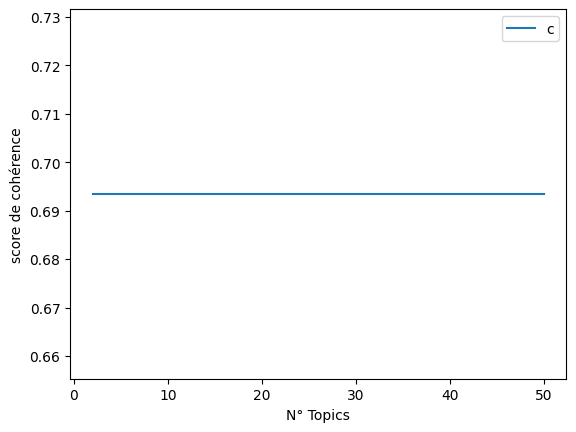

N° Topics = 2  a une valeur de cohérence de 0.6934
N° Topics = 3  a une valeur de cohérence de 0.6934
N° Topics = 4  a une valeur de cohérence de 0.6934
N° Topics = 5  a une valeur de cohérence de 0.6934
N° Topics = 6  a une valeur de cohérence de 0.6934
N° Topics = 7  a une valeur de cohérence de 0.6934
N° Topics = 8  a une valeur de cohérence de 0.6934
N° Topics = 9  a une valeur de cohérence de 0.6934
N° Topics = 10  a une valeur de cohérence de 0.6934
N° Topics = 11  a une valeur de cohérence de 0.6934
N° Topics = 12  a une valeur de cohérence de 0.6934
N° Topics = 13  a une valeur de cohérence de 0.6934
N° Topics = 14  a une valeur de cohérence de 0.6934
N° Topics = 15  a une valeur de cohérence de 0.6934
N° Topics = 16  a une valeur de cohérence de 0.6934
N° Topics = 17  a une valeur de cohérence de 0.6934
N° Topics = 18  a une valeur de cohérence de 0.6934
N° Topics = 19  a une valeur de cohérence de 0.6934
N° Topics = 20  a une valeur de cohérence de 0.6934
N° Topics = 21  a un

In [56]:
show_coherence(coherence_values_1, 2,1,51)

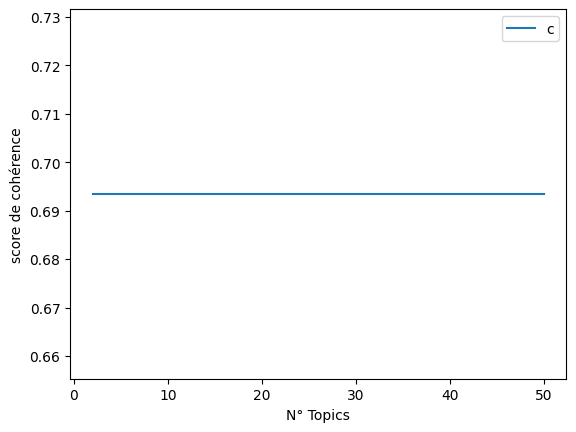

N° Topics = 2  a une valeur de cohérence de 0.6934
N° Topics = 3  a une valeur de cohérence de 0.6934
N° Topics = 4  a une valeur de cohérence de 0.6934
N° Topics = 5  a une valeur de cohérence de 0.6934
N° Topics = 6  a une valeur de cohérence de 0.6934
N° Topics = 7  a une valeur de cohérence de 0.6934
N° Topics = 8  a une valeur de cohérence de 0.6934
N° Topics = 9  a une valeur de cohérence de 0.6934
N° Topics = 10  a une valeur de cohérence de 0.6934
N° Topics = 11  a une valeur de cohérence de 0.6934
N° Topics = 12  a une valeur de cohérence de 0.6934
N° Topics = 13  a une valeur de cohérence de 0.6934
N° Topics = 14  a une valeur de cohérence de 0.6934
N° Topics = 15  a une valeur de cohérence de 0.6934
N° Topics = 16  a une valeur de cohérence de 0.6934
N° Topics = 17  a une valeur de cohérence de 0.6934
N° Topics = 18  a une valeur de cohérence de 0.6934
N° Topics = 19  a une valeur de cohérence de 0.6934
N° Topics = 20  a une valeur de cohérence de 0.6934
N° Topics = 21  a un

In [57]:
# Faible densité
model_list_2, coherence_values_2 = compute_coherence_values(dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=1, passes=5, alpha=0.01, beta=0.01, minimum_probability=0.05)
show_coherence(coherence_values_2, 2,1,51)

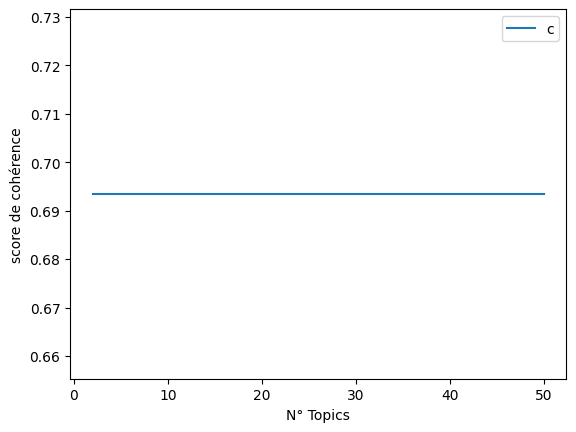

N° Topics = 2  a une valeur de cohérence de 0.6934
N° Topics = 3  a une valeur de cohérence de 0.6934
N° Topics = 4  a une valeur de cohérence de 0.6934
N° Topics = 5  a une valeur de cohérence de 0.6934
N° Topics = 6  a une valeur de cohérence de 0.6934
N° Topics = 7  a une valeur de cohérence de 0.6934
N° Topics = 8  a une valeur de cohérence de 0.6934
N° Topics = 9  a une valeur de cohérence de 0.6934
N° Topics = 10  a une valeur de cohérence de 0.6934
N° Topics = 11  a une valeur de cohérence de 0.6934
N° Topics = 12  a une valeur de cohérence de 0.6934
N° Topics = 13  a une valeur de cohérence de 0.6934
N° Topics = 14  a une valeur de cohérence de 0.6934
N° Topics = 15  a une valeur de cohérence de 0.6934
N° Topics = 16  a une valeur de cohérence de 0.6934
N° Topics = 17  a une valeur de cohérence de 0.6934
N° Topics = 18  a une valeur de cohérence de 0.6934
N° Topics = 19  a une valeur de cohérence de 0.6934
N° Topics = 20  a une valeur de cohérence de 0.6934
N° Topics = 21  a un

In [58]:
# Asymétrique
model_list_3, coherence_values_3 = compute_coherence_values(dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=1, passes=10, alpha='asymmetric', beta=0.9, random_state=42)
show_coherence(coherence_values_3, 2,1,51)

In [59]:
# test par NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Créer une matrice TF-IDF
vectorizer_mdl = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer_mdl.fit_transform([" ".join(text) for text in texts])

# Appliquer la NMF
nmf = NMF(n_components=10, random_state=42).fit(tfidf)

# Afficher les mots les plus importants pour chaque sujet
feature_names = vectorizer_mdl.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic #{topic_idx+1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print("\n")

Topic #1:
project version reference studio core package framework net dll solution


Topic #2:
class type method test code string instance void object return


Topic #3:
service web wcf window configuration client soap application config json


Topic #4:
control application event form window button iframe page wpf text


Topic #5:
task thread exception await async writeline var method return void


Topic #6:
bit machine size int byte program memory code application environment


Topic #7:
file config path image dll folder directory configuration stream line


Topic #8:
list item collection array way int count foreach memory index


Topic #9:
server client connection database sql request entity http com error


Topic #10:
value int property type column return enum array parameter field




### consultons les indices de logs perplexité, de cohérence

In [75]:
from gensim.corpora import Dictionary
id2word = Dictionary(texts)

id2word.filter_extremes(no_below=5, no_above=0.5)  # C'est un exemple, ajustez les valeurs selon vos besoins.
id2word.compactify()

if 4 in id2word:
    print("Word ID 4:", id2word[4])
else:
    print("Word ID 4 does not exist in the dictionary.")

Word ID 4: configure


In [76]:
%%time
optimal_model = model_list[5]

print('\nPerplexity: ', optimal_model.log_perplexity(bow_corpus)) #tfidf_corpus

coherence_model_lda = CoherenceModel(model=optimal_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))


Perplexity:  -16.741029727045863

Coherence Score:  0.3156364908592383
[(0,
  '0.014*"configure" + 0.014*"look" + 0.014*"verify" + 0.013*"copy" + '
  '0.013*"adapter" + 0.012*"status" + 0.012*"day" + 0.012*"type" + 0.012*"try" '
  '+ 0.012*"arraylist" + 0.012*"area" + 0.012*"support" + 0.011*"bcl" + '
  '0.011*"system" + 0.011*"home" + 0.011*"wrap" + 0.011*"membership" + '
  '0.011*"thing" + 0.011*"increment" + 0.011*"connection" + 0.011*"code" + '
  '0.011*"fact" + 0.011*"actionresult" + 0.011*"performance" + 0.011*"list" + '
  '0.011*"addmodelerror" + 0.011*"config" + 0.011*"question" + '
  '0.011*"database" + 0.011*"text"'),
 (1,
  '0.014*"project" + 0.014*"implementation" + 0.013*"wrap" + 0.013*"e" + '
  '0.012*"progresschangedeventargs" + 0.012*"ilist" + 0.012*"get" + '
  '0.012*"password" + 0.012*"list" + 0.012*"entity" + 0.012*"redirect" + '
  '0.012*"query" + 0.012*"public" + 0.012*"support" + 0.012*"bgworker" + '
  '0.011*"field" + 0.011*"bool" + 0.011*"messy" + 0.011*"loginv

### Topic dominant

In [77]:
%%time


original_post = data['Post']
original_cleaned_keywords = data['splitted_tags']

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    print("Nombre de documents dans le corpus : ", len(corpus))
    print("Nombre de documents dans les textes : ", len(texts))

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]])], ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    if len(contents) != len(sent_topics_df):
        print("Attention : La longueur des textes et celle du DataFrame des sujets dominants ne correspondent pas!")
    sent_topics_df = pd.concat([sent_topics_df, contents.reset_index(drop=True)], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=tfidf_corpus, texts=original_post)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

Nombre de documents dans le corpus :  4116
Nombre de documents dans les textes :  4116
CPU times: total: 2.7 s
Wall time: 2.75 s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,4.0,0.2309,"framework, redirectfromloginpage, work, build,...",How can I configure Entity Framework to automa...,NaN
1,1.0,4.0,0.2311,"framework, redirectfromloginpage, work, build,...",How to perform a binary search on IList<T>? <p...,NaN
2,2.0,4.0,0.2309,"framework, redirectfromloginpage, work, build,...",Anonymous methods and delegates <p>I try to un...,NaN
3,3.0,4.0,0.2308,"framework, redirectfromloginpage, work, build,...",How to Unit Test Asp.net Membership? <p>I am n...,NaN
4,4.0,4.0,0.2309,"framework, redirectfromloginpage, work, build,...",Win32 Console app vs. CLR Console app <p>I'm w...,NaN
5,5.0,4.0,0.2309,"framework, redirectfromloginpage, work, build,...",Why can't I drag execution point in IntelliJ (...,NaN
6,6.0,4.0,0.2308,"framework, redirectfromloginpage, work, build,...",Why C# is not allowing non-member functions li...,NaN
7,7.0,4.0,0.2309,"framework, redirectfromloginpage, work, build,...",I need some clarification on the MVC architect...,NaN
8,8.0,4.0,0.2309,"framework, redirectfromloginpage, work, build,...",mex binding error in WCF <p>I am using VSTS 20...,NaN
9,9.0,4.0,0.2311,"framework, redirectfromloginpage, work, build,...",Regex for Money <p>I have <code>asp:TextBox</c...,NaN


## Topic dominant en utilisant NMF

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Définissez vos données d'entrée
original_post = data['Post']
original_cleaned_keywords = data['splitted_tags']

# Créez une instance de TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit-transformez le vectorizer sur vos textes pour obtenir une matrice TF-IDF
tfidf = vectorizer.fit_transform(original_post)

# Créez une instance de NMF avec le nombre de topics souhaité
nmf = NMF(n_components=5, random_state=1).fit(tfidf)

def format_topics_sentences(ldamodel, corpus, texts, vectorizer):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    topic_probabilities = ldamodel.transform(corpus.toarray())  # Convert sparse matrix to dense
    feature_names = vectorizer.get_feature_names_out()  # Get feature names from the vectorizer
    for i, probabilities in enumerate(topic_probabilities):
        dominant_topic = np.argmax(probabilities)
        perc_contribution = np.max(probabilities)
        
        # Get the top 10 words for this topic
        topic_keywords = ", ".join([feature_names[i] for i in ldamodel.components_[dominant_topic].argsort()[:-10 - 1:-1]])
        
        # Create a new row with the dominant topic and its contribution
        sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(dominant_topic), round(perc_contribution, 4), topic_keywords]])], ignore_index=True)

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.reset_index(drop=True)], axis=1)
    return(sent_topics_df)



df_topic_sents_keywords_NMF = format_topics_sentences(ldamodel=nmf, corpus=tfidf, texts=original_post, vectorizer=vectorizer)

# Format
df_dominant_topic_NMF = df_topic_sents_keywords_NMF.reset_index()
df_dominant_topic_NMF = pd.concat([df_dominant_topic_NMF, original_cleaned_keywords], axis=1)
df_dominant_topic_NMF.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic_NMF.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,0.0,0.0405,"code, pre, string, public, new, class, int, me...",How can I configure Entity Framework to automa...,NaN
1,1.0,0.0,0.0805,"code, pre, string, public, new, class, int, me...",How to perform a binary search on IList<T>? <p...,NaN
2,2.0,0.0,0.0522,"code, pre, string, public, new, class, int, me...",Anonymous methods and delegates <p>I try to un...,NaN
3,3.0,0.0,0.0614,"code, pre, string, public, new, class, int, me...",How to Unit Test Asp.net Membership? <p>I am n...,NaN
4,4.0,3.0,0.0799,"net, strong, com, href, http, application, mic...",Win32 Console app vs. CLR Console app <p>I'm w...,NaN
5,5.0,3.0,0.0285,"net, strong, com, href, http, application, mic...",Why can't I drag execution point in IntelliJ (...,NaN
6,6.0,0.0,0.0180,"code, pre, string, public, new, class, int, me...",Why C# is not allowing non-member functions li...,NaN
7,7.0,1.0,0.1103,"li, ul, ol, strong, em, code, href, noreferrer...",I need some clarification on the MVC architect...,NaN
8,8.0,2.0,0.2288,"gt, lt, pre, list, public, binding, div, ifram...",mex binding error in WCF <p>I am using VSTS 20...,NaN
9,9.0,0.0,0.0705,"code, pre, string, public, new, class, int, me...",Regex for Money <p>I have <code>asp:TextBox</c...,NaN


In [66]:
pickle.dump(nmf, open('./models/nmf_model.pkl', 'wb'))
pickle.dump(vectorizer, open('./models/vectorizer.pkl', 'wb'))

### Document significatif 

In [67]:
%%time

sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

CPU times: total: 0 ns
Wall time: 32.6 ms


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,4,0.2311,"framework, redirectfromloginpage, work, build,...",Get File Icon used by Shell <p>In .Net (C# or ...


### Répartition

In [68]:
%%time 
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop

CPU times: total: 0 ns
Wall time: 29.2 ms


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4.0,"framework, redirectfromloginpage, work, build,...",NaN,NaN
4,NaN,NaN,4116.0,1.0


In [81]:
print(len(id2word))  # taille du vocabulaire
print(topic_term_dists.shape)  # (nombre_de_sujets, taille_du_vocabulaire)

2574
(7, 17793)


In [82]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
topic_term_dists = optimal_model.get_topics()
topic_term_dists = topic_term_dists / topic_term_dists.sum(axis=1)[:, None]

new_id2word = corpora.Dictionary(texts)
new_corpus = [new_id2word.doc2bow(text) for text in texts]
new_lda_model = LdaModel(corpus=new_corpus, id2word=new_id2word, num_topics=7, passes=15)


vis = pyLDAvis.gensim_models.prepare(new_lda_model, new_corpus, new_id2word, topic_term_dists=topic_term_dists)
#vis = pyLDAvis.gensim_models.prepare(optimal_model, tfidf_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_tfidf.html')
display(HTML('lda_tfidf.html'))

CPU times: total: 17.2 s
Wall time: 19.7 s


### Prédiction

In [83]:
lda_model = optimal_model
def predict_unsupervised_tags(text):
    """
    Prédire les balises d'un texte prétraité    
    Args:
        text(list): text d'origine        
    Returns:
        relevant_tags(list): liste de tags
    """
    
    corpus_new = id2word.doc2bow(text)
    topics = lda_model.get_document_topics(corpus_new)
    
    #find most relevant topic according to probability
    relevant_topic = topics[0][0]
    relevant_topic_prob = topics[0][1]
    
    for i in range(len(topics)):
        if topics[i][1] > relevant_topic_prob:
            relevant_topic = topics[i][0]
            relevant_topic_prob = topics[i][1]
            
    #retrieve associated to topic tags present in submited text
    potential_tags = lda_model.get_topic_terms(topicid=relevant_topic, topn=20)
    
    relevant_tags = [id2word[tag[0]] for tag in potential_tags if id2word[tag[0]] in text]
    
    return relevant_tags

In [103]:
print(w2v_model) #.wv['net']))
print(X_train_transformed.shape)
print(X_test_transformed.shape)

Word2Vec<vocab=37, vector_size=100, alpha=0.025>
(3292, 10)
(824, 10)


In [105]:
def transform_with_word2vec(data, w2v_model, embedding_dim):
    transformed_data = np.zeros((len(data), embedding_dim))
    for i, text in enumerate(data):
        vectors = [w2v_model.wv[word] for word in text if word in w2v_model.wv]
        if vectors:
            transformed_data[i] = np.mean(vectors, axis=0)
    return transformed_data

X_train_transformed = transform_with_word2vec(X_train, w2v_model, 100)
X_test_transformed = transform_with_word2vec(X_test, w2v_model, 100)

svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
svm_clf.fit(X_train_transformed, train_labels)

def predict_supervised_tags(supervised_model, mlb_model, text, w2v_model, embedding_dim):
    transformed_text = transform_with_word2vec([text], w2v_model, embedding_dim)
    predicted = supervised_model.predict(transformed_text)
    tags = mlb_model.inverse_transform(predicted)
    return tags[0]


In [106]:
def check_tag_prediction(original_text, original_tags, preprocessed_text, supervised_model):
    """
    Vérifier les balises originales par rapport aux balises prédites pour un article.   
    Args:
        post(list) : texte d'origine
        original_tags(list) : preprocessed_tags
    """
       
    predicted_supervised_tags = predict_supervised_tags(supervised_model, mlb, preprocessed_text, w2v_model, embedding_dim)
    predicted_unsupervised_tags = predict_unsupervised_tags(preprocessed_text)
    
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"prédits par le modèle supervisé: {predicted_supervised_tags}")
    print("\n")
    print(f"tags prédits par le modèle non supervisé: {predicted_unsupervised_tags}")

print("Test des 10 premiers documents du corpus\n")
for i in range(10):
    print(f"Document {i}:")
    print("\n")
    check_tag_prediction(filtered_tokenized_vs_original.loc[i,'Post'], 
                         filtered_tokenized_vs_original.loc[i,'splitted_tags'],
                         filtered_tokenized_vs_original.loc[i,'splitted_text'],
                         svm_clf)
    print("-"*100 + "\n")


Test des 10 premiers documents du corpus

Document 0:


Publication originale: 

How can I configure Entity Framework to automatically trim values retrieved for specific columns mapped to char(N) fields? <p>I'm working with a third-party database in which all text values are stored as <code>char(n)</code>. Some of these text values are primary keys, whereas others are just normal human-readable text. For the latter, I want retrieved values to be automatically trimmed.</p>

<p>I know I can add <code>Trim</code> to all of my LINQ to Entities queries, but this is messy, unreliable and unmaintainable. I would like to somehow configure Entity Framework to automatically trim values retrieved from specific columns.</p>

<p>However, I don't know how to do this. I'm using EF's fluent API. The closest thing I've thought of so far is creating additional properties to wrap the real properties with <code>Trim</code> method calls, but this is messy and still not very maintainable. I would also prefe

In [107]:
def check_tag_predction(original_text, original_tags, preprocessed_text, supervised_model):
    """
    Vérifier les balises originales par rapport aux balises prédites pour un article.   
    Args:
        post(list) : texte d'origine
        original_tags(list) : preprocessed_tags
    """
    
    predicted_supervised_tags = predict_supervised_tags(supervised_model, mlb, preprocessed_text, w2v_model, embedding_dim)
    predicted_unsupervised_tags = predict_unsupervised_tags(preprocessed_text)
    
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"prédits par le modèle supervisé: {predicted_supervised_tags}")
    print("\n")
    print(f"tags prédits par le modèle non supervisé: {predicted_unsupervised_tags}")

print("Test des 10 premiers documents du corpus\n")
for i in range(10):
    print(f"Document {i}:")
    print("\n")
    check_tag_predction(filtered_tokenized_vs_original.loc[i,'Post'], 
                    filtered_tokenized_vs_original.loc[i,'splitted_tags'],
                    filtered_tokenized_vs_original.loc[i,'splitted_text'],
                    svm_clf)
    print("-"*100 + "\n")

Test des 10 premiers documents du corpus

Document 0:


Publication originale: 

How can I configure Entity Framework to automatically trim values retrieved for specific columns mapped to char(N) fields? <p>I'm working with a third-party database in which all text values are stored as <code>char(n)</code>. Some of these text values are primary keys, whereas others are just normal human-readable text. For the latter, I want retrieved values to be automatically trimmed.</p>

<p>I know I can add <code>Trim</code> to all of my LINQ to Entities queries, but this is messy, unreliable and unmaintainable. I would like to somehow configure Entity Framework to automatically trim values retrieved from specific columns.</p>

<p>However, I don't know how to do this. I'm using EF's fluent API. The closest thing I've thought of so far is creating additional properties to wrap the real properties with <code>Trim</code> method calls, but this is messy and still not very maintainable. I would also prefe

### Vérification

In [108]:
filename_model = './models/lda_model.pkl'
pickle.dump(lda_model, open(filename_model,'wb'))

filename_dictionary = './models/dictionary.pkl'
pickle.dump(id2word, open(filename_dictionary,'wb'))

## Prédiction NMF

In [109]:
nmf_model = nmf  # Votre modèle NMF déjà formé
vectorizer_model = vectorizer  # Le TfidfVectorizer déjà formé

def predict_unsupervised_tags_nmf(text):
    """
    Prédire les balises d'un texte prétraité    
    Args:
        text(list): text prétraité        
    Returns:
        relevant_tags(list): liste de tags
    """
    # Convert the list of words back to a string
    text_str = ' '.join(text)

    # Transformez le texte avec le TfidfVectorizer
    tfidf_new = vectorizer_model.transform([text_str])

    # Obtenez la distribution des sujets pour ce texte
    topics = nmf_model.transform(tfidf_new)

    # Identifiez le sujet dominant
    dominant_topic = np.argmax(topics[0])

    # Récupérez les 20 mots-clés les plus probables pour ce sujet
    potential_tags = nmf_model.components_[dominant_topic].argsort()[:-20 - 1:-1]

    # Identifiez les tags qui sont présents dans le texte d'origine
    relevant_tags = [vectorizer_model.get_feature_names_out()[i] for i in potential_tags if vectorizer_model.get_feature_names_out()[i] in text]

    return relevant_tags



### Vérification

In [110]:
def check_tag_predction_nmf(original_text, original_tags, preprocessed_text, supervised_model):
    """
    Vérifier les balises originales par rapport aux balises prédites pour un article.   
    Args:
        post(list) : texte d'origine
        original_tags(list) : preprocessed_tags
    """
                                                       
    predicted_supervised_tags = predict_supervised_tags(supervised_model, mlb, preprocessed_text, w2v_model, embedding_dim)
    predicted_unsupervised_tags = predict_unsupervised_tags_nmf(preprocessed_text)
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"prédits par le modèle supervisé: {predicted_supervised_tags}")
    print("\n")
    print(f"tags prédits par le modèle non supervisé: {predicted_unsupervised_tags}")

print("Test des 10 premiers documents du corpus\n")
for i in range(10):
    print(f"Document {i}:")
    print("\n")
    check_tag_predction_nmf(filtered_tokenized_vs_original.loc[i,'Post'], 
                        filtered_tokenized_vs_original.loc[i,'splitted_tags'],
                        filtered_tokenized_vs_original.loc[i,'splitted_text'],
                        svm_clf)
    print("-"*100 + "\n")


Test des 10 premiers documents du corpus

Document 0:


Publication originale: 

How can I configure Entity Framework to automatically trim values retrieved for specific columns mapped to char(N) fields? <p>I'm working with a third-party database in which all text values are stored as <code>char(n)</code>. Some of these text values are primary keys, whereas others are just normal human-readable text. For the latter, I want retrieved values to be automatically trimmed.</p>

<p>I know I can add <code>Trim</code> to all of my LINQ to Entities queries, but this is messy, unreliable and unmaintainable. I would like to somehow configure Entity Framework to automatically trim values retrieved from specific columns.</p>

<p>However, I don't know how to do this. I'm using EF's fluent API. The closest thing I've thought of so far is creating additional properties to wrap the real properties with <code>Trim</code> method calls, but this is messy and still not very maintainable. I would also prefe